In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum', instance='client-enablement/solutions/demo-testing')
backend = service.get_backend('ibm_kyiv')


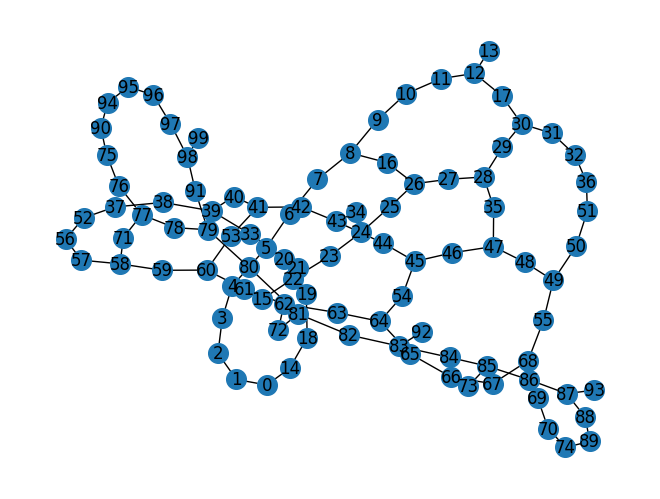

In [2]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np


n = 100  # Number of nodes in graph
reps = 1  # Number of QAOA repetitions
graph_100 = rx.PyGraph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1], 1.0))
graph_100.add_edges_from(elist)
draw_graph(graph_100, node_size=200, with_labels=True, width=1)


In [3]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIII

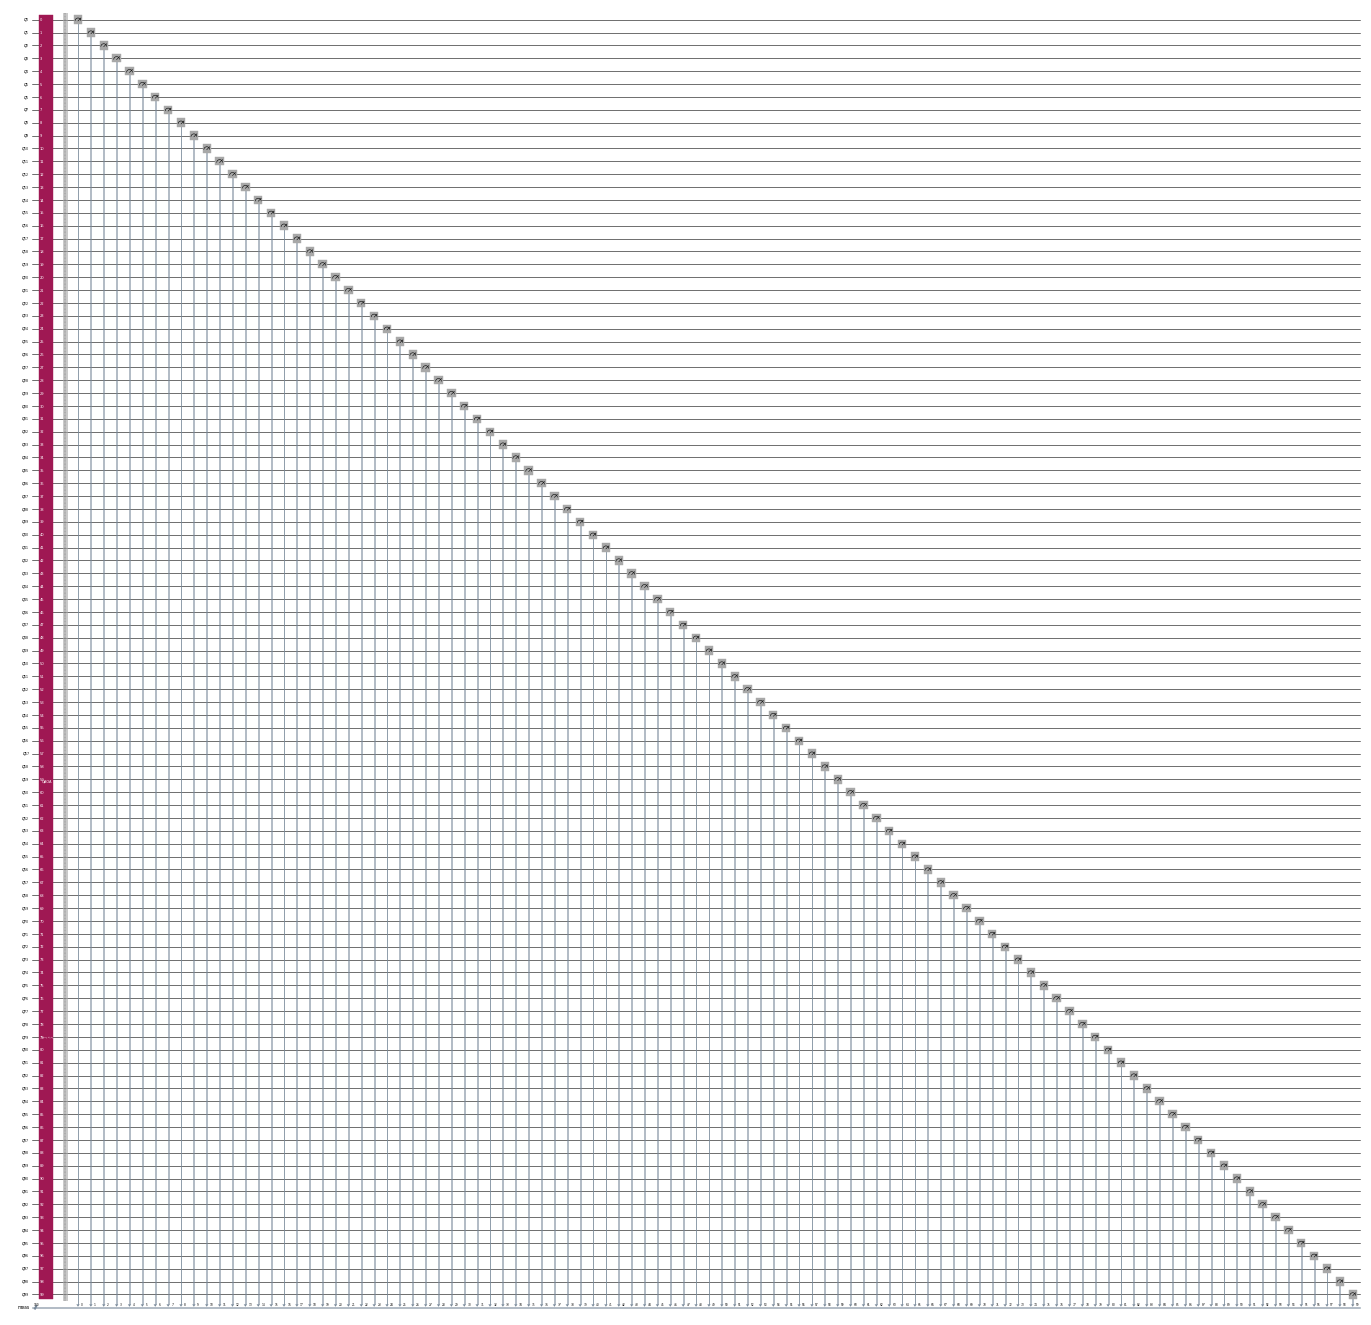

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=1)
circuit_100.measure_all()

circuit_100.draw('mpl', fold=False, scale=0.2, idle_wires=False)

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level = 3,
                                    backend = backend)

candidate_circuit_100 = pm.run(circuit_100)
num_2q_ops = candidate_circuit_100.count_ops()['ecr']
print(f'There are {num_2q_ops} 2Q operations in the circuit')
candidate_circuit_100.draw(output="mpl", idle_wires=False, fold=False)

There are 224 2Q operations in the circuit


In [6]:
_PARITY = np.array([-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8)
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])

In [7]:
from collections.abc import Callable, Iterable

def qaoa_sampler_cost_fun(params, ansatz, hamiltonian, sampler, aggregation=None):
    """Standard sampler-based QAOA cost function to be plugged into optimizer routines.

    Args:
        params (np.ndarray): Parameters for the ansatz.
        ansatz (QuantumCircuit): Ansatz circuit.
        hamiltonian (SparsePauliOp): Hamiltonian to be minimized.
        sampler (QAOASampler): Sampler to be used.
        aggregation (Callable | float | None): Aggregation function to be applied to
            the sampled results. If None, the sum of the expectation values is returned.
            If float, the CVaR with the given alpha is used.
    """
    # job = sampler.run(ansatz, params)
    # sampler_result = job.result()
    # sampled = sampler_result.quasi_dists[0]

    # # a dictionary containing: {state: (measurement probability, value)}
    # evaluated = {
    #     state: (probability, evaluate_sparse_pauli(state, hamiltonian))
    #     for state, probability in sampled.items()
    # }

    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.meas.get_int_counts()
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {key: val/shots for key, val in sampled_int_counts.items()}

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, float(evaluate_sparse_pauli(state, cost_hamiltonian_100)))
        for state, probability in int_count_distribution.items()
    }

    # If aggregation is None, return the sum of the expectation values.
    # If aggregation is a float, return the CVaR with the given alpha.
    # Otherwise, use the aggregation function.
    if aggregation is None:
        result = sum(probability * value for probability, value in evaluated.values())
    elif isinstance(aggregation, float):
        cvar_aggregation = _get_cvar_aggregation(aggregation)
        result = cvar_aggregation(evaluated.values())
    else:
        result = aggregation(evaluated.values())

    result = float(result)

    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict['params'] = params.tolist()
    temp_dict['cvar_fval'] = result
    temp_dict['normal_fval'] = sum(probability * value for probability, value in evaluated.values())
    temp_dict['distribution'] = sampled_int_counts
    temp_dict['evaluated'] = evaluated
    result_dict[iter_counts] = temp_dict
    print(f'Iteration {iter_counts}: {result}')

    return result


def _get_cvar_aggregation(alpha: float | None) -> Callable:
    """Return the CVaR aggregation function with the given alpha.

    Args:
        alpha (float | None): Alpha value for the CVaR aggregation. If None, 1 is used
            by default.
    Raises:
        ValueError: If alpha is not in [0, 1].
    """
    if alpha is None:
        alpha = 1
    elif not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1], but {alpha} was given.")

    def cvar_aggregation(objective_dict: Iterable[tuple[float, float]]) -> float:
        """Return the CVaR of the given measurements.
        Args:
            objective_dict (Iterable[tuple[float, float]]): An iterable of tuples containing
                the measured bit string and the objective value based on the bit string.

        """
        sorted_measurements = sorted(objective_dict, key=lambda x: x[1])
        # accumulate the probabilities until alpha is reached
        accumulated_percent = 0.0
        cvar = 0.0
        for probability, value in sorted_measurements:
            cvar += value * min(probability, alpha - accumulated_percent)
            accumulated_percent += probability
            if accumulated_percent >= alpha:
                break
        return cvar / alpha

    return cvar_aggregation

In [21]:
# TQA initialization parameters
dt = 0.75
p = reps  # Number of layers
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))
print(init_params)

[0.625 0.375]


In [9]:
init_params = [np.pi, np.pi/2]
init_params

[3.141592653589793, 1.5707963267948966]

In [10]:
for el in backend.properties().general:

    if el.name[:2] == 'lf' and el.name[3:] == str(n):
        lf = el.value # layer fidelity
        print('layer fidelity', lf)
        elpg = 1-lf**(1/(n-1)) # elpg
        # print('ELPG', elpg)
        fid_cx = 1 - elpg
        # print('fid_cx', fid_cx)
        gamma_cx = 1/fid_cx**2
        # print('gamma_cx', gamma_cx)
        gamma_circ = gamma_cx*num_2q_ops
        # print('gamma_circ', gamma_circ)
        # print('sqrt(gamma_circ)', np.sqrt(gamma_circ))

cvar_aggregation = 1/np.sqrt(gamma_circ)
print('')
print('The corresponding CVaR aggregation value is: ', cvar_aggregation)
print('To mitigate the twirled noise, increase shots by ', np.sqrt(gamma_circ))

layer fidelity 0.166687810324821

The corresponding CVaR aggregation value is:  0.065617009527
To mitigate the twirled noise, increase shots by  15.239950848240369


In [12]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

iter_counts = 0
result_dict = {}


with Session(backend=backend) as session:
    sampler = Sampler(session=session)

    shots = 1000
    sampler.options.default_shots = int(shots*np.sqrt(gamma_circ))

    # Set error suppression/mitigation options
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"
    sampler.options.twirling.enable_gates = True
    sampler.options.twirling.num_randomizations = "auto"
    sampler.options.twirling.enable_measure = True

    # Run optimization loop
    result = minimize(
        qaoa_sampler_cost_fun,
        init_params,
        args=(candidate_circuit_100, cost_hamiltonian_100, sampler, cvar_aggregation), #(ansatz, hamiltonian, sampler obj, aggregation)
        method="COBYLA",
        tol=1e-2,
    )
print(result)

/var/folders/dk/j4n5f_1d3xs7m8bq81g9gfk80000gn/T/ipykernel_9050/2992360334.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  state: (probability, float(evaluate_sparse_pauli(state, cost_hamiltonian_100)))


Iteration 1: -21.034314100010015
Iteration 2: -20.414275414669103
Iteration 3: -21.186323584158092
Iteration 4: -49.14032071395522
Iteration 5: 20.89368140749958
Iteration 6: -24.546283650902026
Iteration 7: -20.248265056981058
Iteration 8: -55.982248459721454
Iteration 9: -43.574223002270806
Iteration 10: -27.68035440763807
Iteration 11: -55.00218731192445
Iteration 12: -56.65429038963943
Iteration 13: -54.802299624204274
Iteration 14: -58.374272918839885
Iteration 15: -57.506218759363016
Iteration 16: -57.85824072265308
Iteration 17: -58.79629924982984
Iteration 18: -57.94624621347562
Iteration 19: -58.86430349273824
Iteration 20: -58.630288892141984
Iteration 21: -58.81830062253558
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -58.81830062253558
       x: [ 1.984e+00  2.751e+00]
    nfev: 21
   maxcv: 0.0


In [13]:
import json
with open('cvar_result_dict_reps1_tol2_kyiv_100q.json', 'w') as f:
    json.dump(result_dict, f)

In [14]:
sorted_evaluated_cvar = sorted(result_dict[21]['evaluated'].items(), key=lambda x: x[1])
print(sorted_evaluated_cvar[0])

sorted_distribution_cvar = sorted(result_dict[21]['distribution'].items(), key=lambda x: x[1], reverse=True)
print(sorted_distribution_cvar[0])

(843475802485666987435062859061, (6.562110374696503e-05, -76.0))
(815054469320904957983089535093, 1)


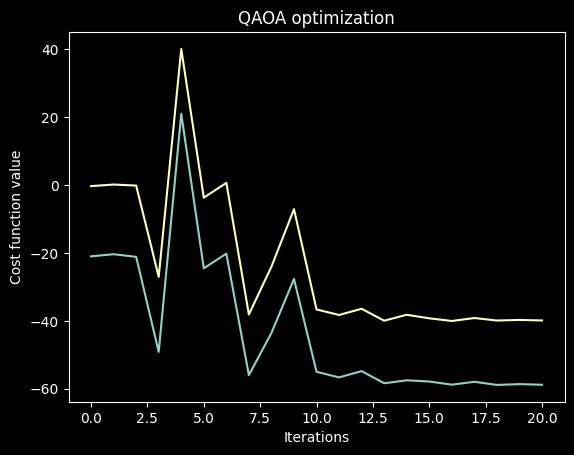

In [15]:
#plot the results
import matplotlib.pyplot as plt
plt.plot([result_dict[i]['cvar_fval'] for i in result_dict], label='CVaR')
plt.plot([result_dict[i]['normal_fval'] for i in result_dict], label='Normal')
plt.xlabel('Iterations')
plt.ylabel('Cost function value')
plt.title('QAOA optimization')
plt.show()


In [16]:
import networkx as nx

curr_cut_size, partition = nx.approximation.one_exchange(graph_100, seed=1)
print(curr_cut_size, partition)


AttributeError: 'rustworkx.PyGraph' object has no attribute 'is_multigraph'

In [ ]:
graph_100.edge_list()

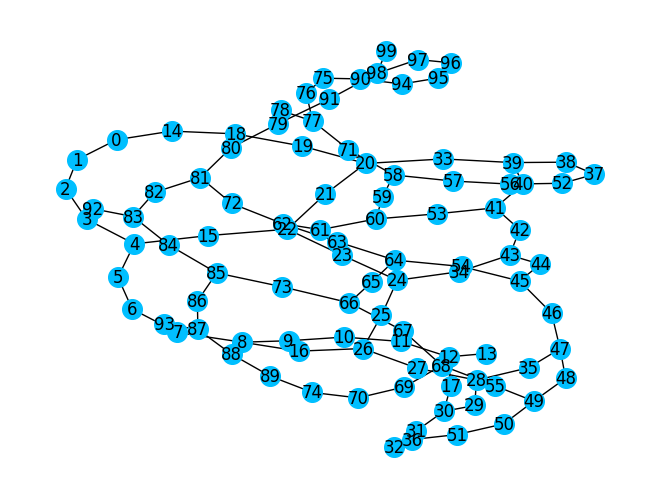

In [17]:
import networkx as nx

n = 100  # Number of nodes in graph

graph_100_nx = nx.Graph()
graph_100_nx.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1]))
graph_100_nx.add_edges_from(elist)

nx.draw(
    graph_100_nx,
    with_labels=True,
    node_size=200,
    node_color="deepskyblue",
    pos=nx.spring_layout(graph_100_nx, seed=1),
)


In [18]:
curr_cut_size, partition = nx.approximation.one_exchange(graph_100_nx, seed=1)
print(curr_cut_size, partition)

112 ({0, 2, 4, 6, 8, 10, 12, 18, 20, 22, 24, 26, 28, 30, 32, 37, 39, 41, 43, 45, 47, 49, 51, 56, 58, 60, 62, 64, 66, 68, 70, 75, 77, 79, 81, 83, 85, 87, 89, 94, 96, 98}, {1, 3, 5, 7, 9, 11, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35, 36, 38, 40, 42, 44, 46, 48, 50, 52, 53, 54, 55, 57, 59, 61, 63, 65, 67, 69, 71, 72, 73, 74, 76, 78, 80, 82, 84, 86, 88, 90, 91, 92, 93, 95, 97, 99})


In [19]:
from qiskit_optimization.applications import Maxcut

maxcut=Maxcut(graph_100_nx)
qp = maxcut.to_quadratic_program()

In [20]:
from qiskit_optimization.algorithms import CplexOptimizer

cplex = CplexOptimizer()
cplex_result = cplex.solve(qp)
print(cplex_result)

fval=112.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=0.0, x_10=1.0, x_11=0.0, x_12=1.0, x_13=0.0, x_14=0.0, x_15=0.0, x_16=0.0, x_17=0.0, x_18=1.0, x_19=0.0, x_20=1.0, x_21=0.0, x_22=1.0, x_23=0.0, x_24=1.0, x_25=0.0, x_26=1.0, x_27=0.0, x_28=1.0, x_29=0.0, x_30=1.0, x_31=0.0, x_32=1.0, x_33=0.0, x_34=0.0, x_35=0.0, x_36=0.0, x_37=1.0, x_38=0.0, x_39=1.0, x_40=0.0, x_41=1.0, x_42=0.0, x_43=1.0, x_44=0.0, x_45=1.0, x_46=0.0, x_47=1.0, x_48=0.0, x_49=1.0, x_50=0.0, x_51=1.0, x_52=0.0, x_53=0.0, x_54=0.0, x_55=0.0, x_56=1.0, x_57=0.0, x_58=1.0, x_59=0.0, x_60=1.0, x_61=0.0, x_62=1.0, x_63=0.0, x_64=1.0, x_65=0.0, x_66=1.0, x_67=0.0, x_68=1.0, x_69=0.0, x_70=1.0, x_71=0.0, x_72=0.0, x_73=0.0, x_74=0.0, x_75=1.0, x_76=0.0, x_77=1.0, x_78=0.0, x_79=1.0, x_80=0.0, x_81=1.0, x_82=0.0, x_83=1.0, x_84=0.0, x_85=1.0, x_86=0.0, x_87=1.0, x_88=0.0, x_89=1.0, x_90=0.0, x_91=0.0, x_92=0.0, x_93=0.0, x_94=1.0, x_95=0.0, x_96=1.0, x_97=0.0, x_98=1.0, x_99=0.0